<a href="https://colab.research.google.com/github/tokarchyn/diabetic-retinopathy-thesis/blob/master/diabetic-retinopathy-ml.ipynb" target="_parent">     
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Imports and basic setups

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

import math
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import copy
import glob
from IPython.display import display, clear_output
import seaborn as sns

if IN_COLAB:
  %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
AUTOTUNE = tf.data.experimental.AUTOTUNE

%precision %.5f
np.set_printoptions(suppress=True, precision=5)

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16754483731173356863
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3035195586986012973
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14853670865424828730
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17510811497741777156
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


##  Define constants

In [0]:
CLASS_NAMES = np.array(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
CLASS_INDEXES = [0,1,2,3,4]
WIDTH = HEIGHT = 224
BATCH_SIZE = 32
PROJECT_DIR = 'drive/My Drive/diabetic-retinopathy-thesis'
BASE_IMAGE_DIR = os.path.join(PROJECT_DIR, 'train_processed')
TRAIN_LABELS_PATH = os.path.join(PROJECT_DIR, 'trainLabels.csv')

# Process dataframe 

In [0]:
def load_df():
  df = pd.read_csv(TRAIN_LABELS_PATH)
  df['image_path'] = BASE_IMAGE_DIR + '/' + df['image'].astype(str) + '.jpeg'
  df = df.drop(columns=['image'])
  return df

def remove_unexist(df):
  all_images = glob.glob(BASE_IMAGE_DIR + "/*")
  while len(all_images) == 0:
    all_images = glob.glob(BASE_IMAGE_DIR + "/*")
  print('Found', len(all_images), 'images')
  df['exists'] = df['image_path'].map(lambda p: p in all_images)
  df = df[df['exists']].drop(columns=['exists'])
  print('Number of existed images is', len(df))
  return df

def train_val_split(df):
  train_img, val_img = train_test_split(df['image_path'], 
                                        test_size = 0.20, 
                                        random_state = 2020,
                                        stratify = df['level'].to_frame())
  train_df = df[df['image_path'].isin(train_img)]
  val_df = df[df['image_path'].isin(val_img)]
  print('Train dataframe size:', train_df.shape[0], 'Validation dataframe size:', val_df.shape[0])
  return train_df, val_df

def calc_weights(df):
  level_counts = df['level'].value_counts().sort_index()
  weights = {cls: len(df) / count for cls, count in enumerate(level_counts)}
  print('Weights for each level:\n', weights)
  return weights

def get_samples_of_level(df, level, count):
  to_add = []
  it = iter(df[df['level']==level].iterrows())

  while count > len(to_add):
    _, row = None, None
    try:
      _, row = next(it)
    except StopIteration:
      it = iter(df[df['level']==level].iterrows())
      _, row = next(it)
    to_add.append(copy.deepcopy(row))

  return to_add

# Upsampling and Downsampling based on multiplicator or exact count for each category
# For example multipliers={0: 2} will take 2 times more samples of category 0 than exist.
def balancing(df, multipliers=None, counts=None):
  max_level_count = df['level'].value_counts().max()

  for level in df['level'].unique():
    count_of_level = df[df['level']==level].count()[0]

    count_diff = 0
    if multipliers != None:
      if level in multipliers:
        count_diff = int(count_of_level * multipliers[level]) - count_of_level
    elif counts != None:
      if level in counts:
        count_diff = counts[level] - count_of_level
    else:
      if count_of_level == max_level_count:
        continue
      count_diff = max_level_count - count_of_level

    if count_diff == 0:
      continue
    print('Need to add(or remove)',count_diff, 'copies of level', level, 'where count of level is', count_of_level)
    if count_diff < 0:
      df_level = df[df['level'] == level] 
      df = df.drop(df_level.sample(count_diff * -1).index)
    else:    
      df = df.append(get_samples_of_level(df, level, count_diff), ignore_index=True)

  return df

def shrink_dataset_equally(df, number_of_each_level=None):
  levels = df['level'].unique()

  if number_of_each_level is None:
    number_of_each_level = df['level'].value_counts().min()

  def get_rows(df_tmp):
    size = len(df_tmp)
    return df_tmp.sample(number_of_each_level) if size >= number_of_each_level else df_tmp

  df_tmp = get_rows(df[df['level'] == levels[0]])
  for l in levels[1:]:
      df_tmp = df_tmp.append(get_rows(df[df['level'] == l]), ignore_index=True)
  return df_tmp

def shrink_dataset(df, count):
  return df[:count]

def shuffle(df):
  df = df.sample(frac=1).reset_index(drop=True)
  return df

def prepare_data():
  df = load_df()
  df = remove_unexist(df)
  df = shuffle(df)
  # df = shrink_dataset(df, 10000)

  train_df, val_df = train_val_split(df)
  # train_df = balancing(train_df) # take the same number of samples as majority category has
  # train_df = balancing(train_df, multipliers={0:0.3, 1:0.7, 2:0.4, 3:2, 4:2})
  train_df = balancing(train_df, counts={0:6000, 1:6000, 2:6000, 3:6000, 4:6000}) # take some samples from each category
  # train_df = shrink_dataset_equally(train_df)
  train_df = shuffle(train_df)
  weights = calc_weights(train_df)

  return train_df, val_df, weights

In [142]:
train_df, val_df, weights = prepare_data()

Found 35126 images
Number of existed images is 35126
Train dataframe size: 28100 Validation dataframe size: 7026
Need to add(or remove) -14648 copies of level 0 where count of level is 20648
Need to add(or remove) 1766 copies of level 2 where count of level is 4234
Need to add(or remove) 4046 copies of level 1 where count of level is 1954
Need to add(or remove) 5434 copies of level 4 where count of level is 566
Need to add(or remove) 5302 copies of level 3 where count of level is 698
Weights for each level:
 {0: 5.0, 1: 5.0, 2: 5.0, 3: 5.0, 4: 5.0}


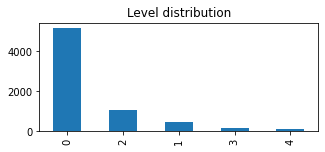

In [8]:
val_df['level'].value_counts().plot(kind='bar', figsize=(5,2), title='Level distribution')

# Build input pipeline

#### Augmentation functions

In [0]:
def rotate(x):
  # Rotate 0, 90, 180, 270 degrees
  return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def flip(x):
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  return x

def color(x):
  x = tf.image.random_hue(x, 0.14)
  x = tf.image.random_saturation(x, 0.7, 1.5)
  x = tf.image.random_brightness(x, 0.1)
  x = tf.image.random_contrast(x, 0.8, 1.5)
  return x

def zoom(x):
  # Generate 20 crop settings, ranging from a 1% to 10% crop.
  scales = list(np.arange(0.9, 1, 0.01))
  boxes = np.zeros((len(scales), 4))

  for i, scale in enumerate(scales):
    x1 = y1 = 0.5 - (0.5 * scale)
    x2 = y2 = 0.5 + (0.5 * scale)
    boxes[i] = [x1, y1, x2, y2]

  def random_crop(img):
    # Create different crops for an image
    crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(HEIGHT, WIDTH))
    # Return a random crop
    return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

  choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

  # Only apply cropping 50% of the time
  return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))


def augment(dataset, aug_probability=1):
  augmentations = [flip, rotate, color, zoom]

  def augment_map(img, level, aug_fun):
    # return (aug_fun(img), level)
    return (tf.cond(tf.math.argmax(level, axis = 0) == 0, lambda: img, lambda: aug_fun(img)), level)
    # choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    # return (tf.cond(choice < aug_probability, lambda: img, lambda: aug_fun(img)),
    #         level)
    
  # Add the augmentations to the dataset
  for f in augmentations:
    dataset = dataset.map(lambda img, level: augment_map(img,level,f), num_parallel_calls=AUTOTUNE)

  # Make sure that the values are still in [0, 1]
  dataset = dataset.map(lambda img, level: (tf.clip_by_value(img, 0, 1),level), num_parallel_calls=AUTOTUNE)
  return dataset

#### Work with batches

In [0]:
def get_input_shape():
  return (HEIGHT, WIDTH, 3)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_label(level):
  return tf.cast(level == CLASS_INDEXES, dtype=tf.float32)

def process_path(file_path, level):
  label = get_label(level)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def prepare(ds, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def show_batch(image_batch, label_batch, number_to_show=4, predicted_labels=None):
  row_count = math.ceil(number_to_show / 4)
  fig, m_axs = plt.subplots(row_count, 4, figsize = (16, row_count * 4))
  for i, (c_x, c_y, c_ax) in enumerate(zip(image_batch, label_batch, m_axs.flatten())):
    c_ax.imshow(c_x)
    real_level = CLASS_NAMES[c_y==1][0]
    pred_level = ''
    title = 'Real level: ' + real_level
    if predicted_labels is not None:
      pred_level = CLASS_NAMES[predicted_labels[i]]
      title = title + '\nPredicted one: ' + pred_level
    c_ax.set_title(title, color='g' if pred_level == '' or real_level == pred_level else 'r')
    c_ax.axis('off')     

def dataset_from_tensor_slices(df):
  return tf.data.Dataset.from_tensor_slices((
      df['image_path'].to_numpy(copy=True),
      df['level'].to_numpy(copy=True)))

def create_datasets(train_df, val_df):
  train_ds = dataset_from_tensor_slices(train_df)
  val_ds = dataset_from_tensor_slices(val_df)

  train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  # train_ds = train_ds.cache()
  # train_ds = train_ds.cache('train_cache')
  train_ds = augment(train_ds)
  train_ds = prepare(train_ds)

  val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  # val_ds = val_ds.cache()
  # val_ds = val_ds.cache('val_cache')
  val_ds = prepare(val_ds)
  
  return train_ds, len(train_df), val_ds, len(val_df)

In [0]:
train_ds, train_count, val_ds, val_count = create_datasets(train_df, val_df)

# Define callbacks and metrics

#### Training History Callback
Helps with persist all metrics and weights in situation when you interupt training

In [0]:
class TrainingHistoryCallback(tf.keras.callbacks.Callback):
  def __init__(self, metrics, save_weights=True):
    self.metrics = {}
    self.weights = []
    self.save_weights = save_weights
    for m in metrics:
      self.metrics[m] = []
      self.metrics['val_' + m] = []

  def on_epoch_end(self, epoch, logs=None):
    for key in self.metrics.keys():
      self.metrics[key].append(logs.get(key))
    if self.save_weights:
      self.weights.append([])
      for l in model.layers:
        self.weights[len(self.weights)-1].append(l.get_weights())

#### Cohen Kappa loss and metric
Intersting idea. Instead of optimizing standart loss we can optimize directly Cohen Kappa, which is used in Kaggle competitions. This metric is better choice for imbalance data set.

In [0]:
def cohen_kappa_loss(y_true, y_pred, row_label_vec, col_label_vec, weight_mat,  eps=1e-6, dtype=tf.float32):
    labels = tf.matmul(y_true, col_label_vec)
    weight = tf.pow(tf.tile(labels, [1, tf.shape(y_true)[1]]) - tf.tile(row_label_vec, [tf.shape(y_true)[0], 1]), 2)
    weight /= tf.cast(tf.pow(tf.shape(y_true)[1] - 1, 2), dtype=dtype)
    numerator = tf.reduce_sum(weight * y_pred)
    
    denominator = tf.reduce_sum(
        tf.matmul(
            tf.reduce_sum(y_true, axis=0, keepdims=True),
            tf.matmul(weight_mat, tf.transpose(tf.reduce_sum(y_pred, axis=0, keepdims=True)))
        )
    )
    
    denominator /= tf.cast(tf.shape(y_true)[0], dtype=dtype)
    
    return tf.math.log(numerator / denominator + eps)

class CohenKappaLoss(tf.keras.losses.Loss):
    def __init__(self,
                 num_classes,
                 name='cohen_kappa_loss',
                 eps=1e-6,
                 dtype=tf.float32):
        super(CohenKappaLoss, self).__init__(name=name, reduction=tf.keras.losses.Reduction.NONE)
        
        self.num_classes = num_classes
        self.eps = eps
        self.dtype = dtype
        label_vec = tf.range(num_classes, dtype=dtype)
        self.row_label_vec = tf.reshape(label_vec, [1, num_classes])
        self.col_label_vec = tf.reshape(label_vec, [num_classes, 1])
        self.weight_mat = tf.pow(
            tf.tile(self.col_label_vec, [1, num_classes]) - tf.tile(self.row_label_vec, [num_classes, 1]),
        2) / tf.cast(tf.pow(num_classes - 1, 2), dtype=dtype)


    def call(self, y_true, y_pred, sample_weight=None):
        return cohen_kappa_loss(
            y_true, y_pred, self.row_label_vec, self.col_label_vec, self.weight_mat, self.eps, self.dtype
        )


    def get_config(self):
        config = {
            "num_classes": self.num_classes,
            "eps": self.eps,
            "dtype": self.dtype
        }
        base_config = super(CohenKappaLoss, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Recall of sick category
Treats all sick people as one category. The lower recall, means we skip more pacient who needs the treatment.  

In [0]:
class Recall(tf.keras.metrics.Metric):

    def __init__(self, name='recall_multi', **kwargs):
      super(Recall, self).__init__(name=name, **kwargs)
      self.builtin_metric = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
      non_healthy_gt = tf.math.greater(tf.math.argmax(y_true, axis=1), 0)
      non_healthy_pr = tf.math.greater(tf.math.argmax(y_pred, axis=1), 0)
      self.builtin_metric.update_state(non_healthy_gt, non_healthy_pr)

    def result(self):
      return self.builtin_metric.result()

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.builtin_metric.reset_states()

#### **List callbacks and metrics to use in model**

In [0]:
def get_callbacks(save_best_models=True, early_stopping=True, reduce_lr_on_plateau=True):
  callbacks = []
  if save_best_models:
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        os.path.join(PROJECT_DIR, 'models/model.e_{epoch:02d}-acc_{val_categorical_accuracy:.2f}-f1_{val_f1_score}.hdf5'), 
        monitor='val_categorical_accuracy', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto'))
  if early_stopping:
    callbacks.append(tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy', 
        patience=20, 
        restore_best_weights=True))
  if reduce_lr_on_plateau:
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=3, 
        verbose=1, 
        mode='auto', 
        epsilon=0.0001, 
        cooldown=5, 
        min_lr=0.00001))
  return callbacks

def top_2_accuracy(in_gt, in_pred):
  return tf.keras.metrics.top_k_categorical_accuracy(in_gt, in_pred, k=2)

def get_metrics():
  return ['categorical_accuracy', tfa.metrics.F1Score(len(CLASS_INDEXES)), Recall(), top_2_accuracy]

# Model Definitions

#### My Custom Model

In [0]:
def get_model():
  model = models.Sequential()

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=get_input_shape()))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(2048, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2048, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(len(CLASS_NAMES), activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=get_metrics())
  return model

#### Vgg-19
[Lecture from Stanford](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf)

In [0]:
def get_vgg_model():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = get_input_shape()))
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
  model.add(MaxPooling2D((2, 2)))
  # model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
  model.compile(optimizer = optimizer, loss = CohenKappaLoss(5), metrics=get_metrics())
  return model

#### Inception v3
The Fine-Tuning technique is used here. 

In [0]:
def get_inception_v3(train, train_count, weights, freeze_layers_number):
  # create the base pre-trained model
  base_model = InceptionV3(weights='imagenet', 
                           include_top=False, 
                           input_shape=(HEIGHT, WIDTH, 3))

  # add a global spatial average pooling layer
  x = base_model.output
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  # x = Conv2D(256, (3, 3), strides=1,  padding = "same", activation = "relu")(x)
  # x = Conv2D(256, (3, 3), strides=1,  padding = "same", activation = "relu")(x)
  # x = MaxPooling2D((3, 3), strides=2)(x)
  # x = BatchNormalization()(x)

  # let's add a fully-connected layer
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False
    
  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy')

  # train the model on the new data for a few epochs
  model.fit(train, steps_per_epoch=train_count // BATCH_SIZE, epochs=1,
          class_weight=weights)

  # at this point, the top layers are well trained and we can start fine-tuning
  # convolutional layers from inception V3. We will freeze the bottom N layers
  # and train the remaining top layers.

  # let's visualize layer names and layer indices to see how many layers
  # we should freeze:
  # for i, layer in enumerate(base_model.layers):
  #   print(i, layer.name)

  # we chose to train the top 2 inception blocks, i.e. we will freeze
  # the first 249(172) layers and unfreeze the rest:
  for layer in model.layers[:freeze_layers_number]:
    layer.trainable = False
  for layer in model.layers[freeze_layers_number:]:
    layer.trainable = True

  # we need to recompile the model for these modifications to take effect
  # we use SGD with a low learning rate
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss='categorical_crossentropy',
                metrics=get_metrics())

  # we train our model again (this time fine-tuning the top 2 inception blocks
  # alongside the top Dense layers
  
  return model

#### All-Cnn
Proposed [here](https://link.springer.com/chapter/10.1007/978-3-030-34869-4_21)

In [0]:
def get_all_cnn_model():
  model = Sequential()

  model.add(Conv2D(32, (7, 7), strides=1, activation = "relu",  padding = "valid", input_shape = get_input_shape()))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, (5, 5), strides=1, activation = "relu",  padding = "valid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, (3, 3), strides=2, activation = "relu",  padding = "valid"))

  model.add(Conv2D(64, (3, 3), strides=1, activation = "relu",  padding = "valid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, (3, 3), strides=2, activation = "relu",  padding = "valid"))

  model.add(Conv2D(128, (3, 3), strides=1, activation = "relu",  padding = "valid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), strides=2, activation = "relu",  padding = "valid"))

  model.add(Conv2D(128, (3, 3), strides=1, activation = "relu",  padding = "valid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (1, 1), strides=1, activation = "relu",  padding = "valid"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(5, (1, 1), strides=1, activation = "relu",  padding = "valid"))
  model.add(Flatten())
  model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=get_metrics())
  return model

#### **Create model**

In [0]:
try:
  del model
except:
  print('There is no model defined')
# model = get_model()
# model = get_vgg_model()
# model = get_alex_model()
# model = get_inception_v3(train_ds, train_count, None, 172)
model = get_all_cnn_model()
# model.summary()

# Training

In [155]:
callbacks = get_callbacks(save_best_models=False, early_stopping=False)
callack_history = TrainingHistoryCallback(['loss', 'categorical_accuracy', 'f1_score'])
callbacks.append(callack_history)

history = model.fit(train_ds, steps_per_epoch=train_count // BATCH_SIZE, 
          validation_data=val_ds, validation_steps=val_count // BATCH_SIZE,
          # class_weight=weights,
          epochs=80,
          callbacks=callbacks
          )

Epoch 1/80
937/937 [==============================] - 229s 244ms/step - loss: 1.9934 - categorical_accuracy: 0.2457 - f1_score: 0.2440 - recall_multi: 0.8206 - top_2_accuracy: 0.4595 - val_loss: 1.0838 - val_categorical_accuracy: 0.7343 - val_f1_score: 0.1694 - val_recall_multi: 0.0000e+00 - val_top_2_accuracy: 0.7583 - lr: 0.0010
Epoch 2/80
937/937 [==============================] - 231s 246ms/step - loss: 1.6045 - categorical_accuracy: 0.3101 - f1_score: 0.2980 - recall_multi: 0.8408 - top_2_accuracy: 0.5248 - val_loss: 1.0321 - val_categorical_accuracy: 0.7343 - val_f1_score: 0.1694 - val_recall_multi: 5.3763e-04 - val_top_2_accuracy: 0.7594 - lr: 0.0010
Epoch 3/80
937/937 [==============================] - 231s 246ms/step - loss: 1.4618 - categorical_accuracy: 0.3490 - f1_score: 0.3294 - recall_multi: 0.8593 - top_2_accuracy: 0.5564 - val_loss: 1.0773 - val_categorical_accuracy: 0.7339 - val_f1_score: 0.1693 - val_recall_multi: 5.3763e-04 - val_top_2_accuracy: 0.7617 - lr: 0.0010
E

Or load model from file

In [0]:
loaded_model = tf.keras.models.load_model(
    os.path.join(PROJECT_DIR, 'models', 'model.17-0.76.hdf5'),
    {'top_2_accuracy' : top_2_accuracy}
)

# Visualization
#### Definitions

In [0]:
def plot_filters(model, number_to_plot):
  layer_outputs = [layer.output for layer in model.layers[-number_to_plot:]] # Extracts the outputs of the top 12 layers
  activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
  activations = activation_model.predict(image_batch) # Returns a list of five Numpy arrays: one array per layer activation
  # first_layer_activation = activations[1]
  # plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

  layer_names = []
  for layer in model.layers[:8]:
      layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
      
  images_per_row = 16

  for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
      n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

def plot_metric(metrics, metric_name):
  plt.plot(metrics[metric_name])
  plt.plot(metrics['val_' + metric_name])
  plt.title(metric_name)
  plt.ylabel(metric_name)
  plt.xlabel('epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()

def plot_f1(metrics):
  fig, m_axs = plt.subplots(1, 2, figsize=(25,5))
  
  m_axs[0].plot(metrics['f1_score'])
  m_axs[0].set_ylabel('f1_score')
  m_axs[0].set_xlabel('epoch')
  m_axs[0].set_title('Training')
  m_axs[0].legend(CLASS_NAMES, loc='upper left')
  
  m_axs[1].plot(metrics['val_f1_score'])
  m_axs[1].set_ylabel('val_f1_score')
  m_axs[1].set_xlabel('epoch')
  m_axs[1].set_title('Validation')
  m_axs[1].legend(CLASS_NAMES, loc='upper left')

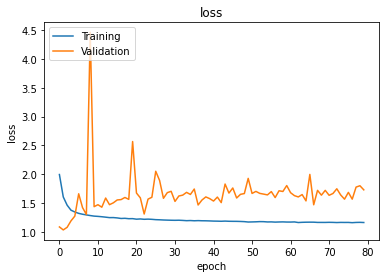

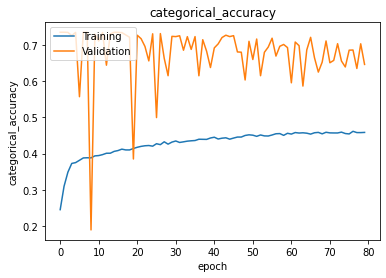

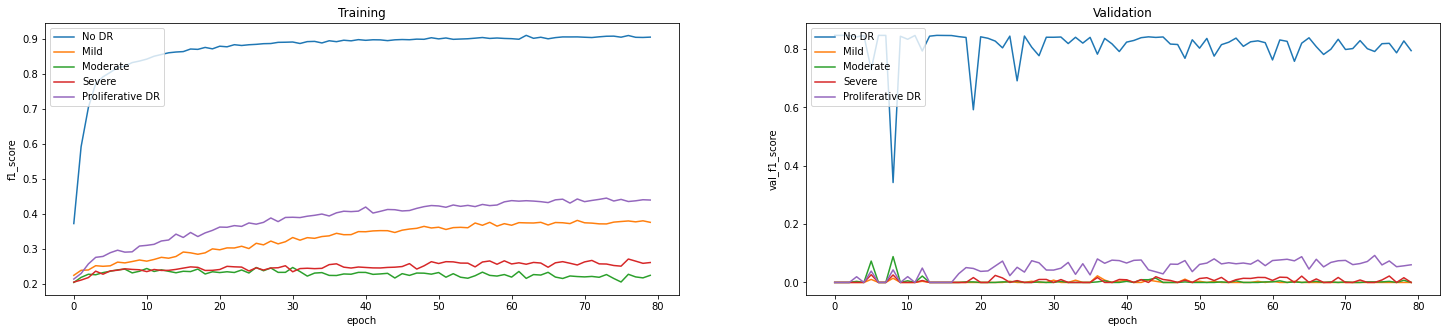

In [157]:
plot_metric(callack_history.metrics, 'loss')
plot_metric(callack_history.metrics, 'categorical_accuracy')
plot_f1(callack_history.metrics)

## Validation

In [0]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
model_to_val = model

image_batch, label_batch = next(iter(val_ds))
model_to_val.evaluate(image_batch, label_batch, BATCH_SIZE)
predicted_probabilities = model_to_val.predict(image_batch)
print('Predicted probabilities:', predicted_probabilities)
predicted_labels = np.argmax(predicted_probabilities,axis=1)
print('Labels:', np.argmax(label_batch,axis=1))
print('Predicted labels:', predicted_labels)
show_batch(image_batch.numpy(), label_batch.numpy(),predicted_labels)

NameError: ignored

# Other

Correctness of loss [CS231](http://cs231n.github.io/neural-networks-3/#sanitycheck) <font color='green'>OK</font>

Loss should be equal -ln(1/len(classes))

In [0]:
-np.log(1/len(CLASS_NAMES))

1.6094379124341003